In [ ]:
#import block
import tensorflow as tf
import h5py
import numpy as np
import json
import pandas as pd
import math
from matplotlib import pyplot as plt
from sklearn.utils import shuffle
from google.colab import files

In [ ]:
#Function block for grabbing a section of the data
def grabData(hf, step=1):
  samples = hf['X'][::step]
  modulation_classes = hf['Y'][::step]
  

  mod_array = np.zeros(len(modulation_classes))
  i = 0
  for x in modulation_classes:
    mod_array[i] = np.where(x==1)[0][0]
    i = i + 1

  return samples, mod_array

In [ ]:
#function block for splitting dataset into training, validation, and testing
#creates tf.Dataset objects
def datasetSplit(samples, mod, training_index=.8, validation_index=.1):
  trn_ind = math.floor(len(mod) * training_index)

  training_set, training_label = samples[:trn_ind:], mod[:trn_ind:]
  validation_set, validation_label = samples[trn_ind::], mod[trn_ind::]

  tr_dataset = tf.data.Dataset.from_tensor_slices((training_set, training_label))
  val_dataset = tf.data.Dataset.from_tensor_slices((validation_set, validation_label))

  return tr_dataset, val_dataset

In [ ]:
#function for performing changes to the tf.Dataset objects like batching, shuffling, etc.
def datasetManip(dset, batch_s=100, buf_s=1000, drop_rem=True):
  dset_trans = dset.shuffle(buffer_size=buf_s).batch(batch_s, drop_remainder=drop_rem)
  return dset_trans

In [ ]:
#function block for compiling and fitting model
#returns the history callback of the trained model
def trainModel(model, trn, val, num_epochs=10):
  #model.compile(optimizer=optim, loss=loss_func, metrics=['accuracy'])
  model.summary()
  model_history = model.fit(trn, epochs=num_epochs, validation_data=val, verbose=1)
  return model_history

In [ ]:
#function block to plot a model's loss and accuracy through its history
def plotHistory(hist, plot_title):
  #summarize history for accuracy
  plt.plot(hist.history['accuracy'])
  plt.plot(hist.history['val_accuracy'])
  
  full_title = plot_title + " accuracy"
  plt.title(full_title)
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  
  plt.show()
  #summarize history for loss
  plt.plot(hist.history['loss'])
  plt.plot(hist.history['val_loss'])
  
  full_title = plot_title + " loss"
  plt.title(full_title)
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  
  plt.show()

Would you like to directly upload your hdf5(1) or import it from drive(2): 1


Saving prediction.hdf5 to prediction.hdf5
Is the file uploaded zipped(1)? 0
['X', 'Y']
For the model, is it zipped(1) on google drive? 1
Enter the file path for the model: /content/drive/MyDrive/three_dense.zip
content/three_dense
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_38 (Conv1D)          (None, 1022, 64)          448       
                                                                 
 max_pooling1d_38 (MaxPoolin  (None, 511, 64)          0         
 g1D)                                                            
                                                                 
 conv1d_39 (Conv1D)          (None, 509, 64)           12352     
                                                                 
 max_pooling1d_39 (MaxPoolin  (None, 254, 64)          0         
 g1D)                                                            
                     

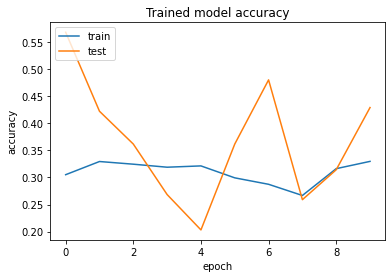

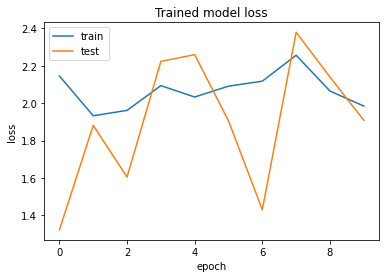

In [ ]:
#MAIN BLOCK
def main():
  #if-else block for uploading hdf5 file
  user_input = input("Would you like to directly upload your hdf5(1) or import it from drive(2): ")
  if(int(user_input) == 1):
    hdf_upload = files.upload()
    hdf_val = list(hdf_upload.keys())
    hdf_key = hdf_val[0]
    
    user_input = input("Is the file uploaded zipped(1)? ")
    if(int(user_input) == 1):
      !unzip -qq $hdf_key
    
    hdf_name = hdf_key.split(".")
    hdf_name = hdf_name[0] + ".hdf5"
    
    #For simplification, hdf5 format should be a group for the samples(X) and a group for the label(Y)
    hdf5_file = h5py.File(hdf_name,  'r')
    print(list(hdf5_file.keys()))
  else:
    file_path = input("Enter in the path of the file in google drive")
    
    user_input = input("Is the file uploaded zipped(1)? ")
    if(int(user_input) == 1):
      !unzip -qq $file_path
      
      path_list = file_path.split("/")
      file_name = path_list[-1]
      file_split = file_name.split(".")
      file_raw = file_split[0]
      
      file_raw = file_raw + ".hdf5"
      hdf5_file = h5py.File(file_raw, 'r')
    
    hdf5_file = h5py.File(file_path, 'r')
    print(list(hdf5_file.keys()))

  #if-else block for uploading hdf5
  user_input = input("For the model, is it zipped(1) on google drive? ")
  if(int(user_input) == 1):
    file_path = input("Enter the file path for the model: ")
    !unzip -qq $file_path 
    file_split = file_path.split("/")
    file_split = file_split[-1].split(".")
    model_dir = file_split[0]
    model_dir = "content/" + model_dir
    print(model_dir)
    loaded_model = tf.keras.models.load_model(model_dir)
  else:
    file_path = input("Enter the file path for the model: ")
    loaded_model = tf.keras.models.load_model(file_path)

  fraction = 1
  samples, modul = grabData(hdf5_file, fraction)
  training_set, validation_set = datasetSplit(samples, modul)
  training_set = datasetManip(training_set)
  validation_set = datasetManip(validation_set)

  model_history = trainModel(loaded_model, training_set, validation_set)
  plotHistory(model_history, "Trained model")
  loaded_model.save("New_trained_model")


  










if __name__ == "__main__":
    main()